# Helmholtz equation over a 2D square domain with a hole
$ \frac{\mathrm{d}^2u}{\mathrm{d}x^2} + \frac{\mathrm{d}^2u}{\mathrm{d}y^2} + (2 \pi)^2u = (2\pi)^2 sin(2\pi x) sin(2\pi y) $

#### exact solution:
$ u(x,y) = sin(2\pi x) sin(2\pi y) $


In [1]:
#! pip install deepxde

In [2]:
import deepxde as dde
import torch
import numpy as np
import matplotlib.pyplot as plt
print('___________________________________')
if torch.cuda.is_available():
        print("running on GPU")
else:
        print("running on CPU")
print('device: ',torch.cuda.get_device_name())
torch.set_default_device("cuda")
print('available GPUs:' , torch.cuda.device_count())
print('current device is:',torch.cuda.current_device())

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


___________________________________
running on GPU
device:  NVIDIA GeForce RTX 3070 Laptop GPU
available GPUs: 1
current device is: 0


In [3]:
n = 1
l = 1
R = 1 / 4

precision_train = 15
precision_test = 30

weight_inner = 10
weight_outer = 100
iterations = 5000
learning_rate = 1e-3
num_dense_layers = 3
num_dense_nodes = 350
activation = "sin"

k0 = 2 * np.pi * n
wave_len = 1 / n

sin = torch.sin

In [4]:
# exact solution
def func(x):
    return np.sin(k0 * x[:, 0:1]) * np.sin(k0 * x[:, 1:2])

# boundaries

def boundary_outer(x, on_boundary):
    return on_boundary and outer.on_boundary(x)

def boundary_inner(x, on_boundary):
    return on_boundary and inner.on_boundary(x)

In [5]:
def neumann(x):
  grad = np.array(
      [
          k0 * np.cos(k0 * x[:, 0:1]) * np.sin(k0 * x[:, 1:2]),
          k0 * np.sin(k0 * x[:, 0:1]) * np.cos(k0 * x[:, 1:2]),
      ]
  )

  normal = -inner.boundary_normal(x)
  normal = np.array([normal]).T
  result = np.sum(grad * normal, axis=0)
  return result

In [6]:
# defining geometery
outer = dde.geometry.Rectangle([-l / 2.0, -l / 2.0], [l / 2.0, l / 2.0])
inner = dde.geometry.Disk([0, 0], R)

geom = outer - inner

hx_train = wave_len / precision_train
nx_train = int(1 / hx_train)

hx_test = wave_len / precision_test
nx_test = int(1 / hx_test)

bc_inner = dde.icbc.NeumannBC(geom, neumann, boundary_inner)
bc_outer = dde.icbc.DirichletBC(geom, func, boundary_outer)

In [7]:
# defining pde
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)
    f = k0**2 * sin(k0 * x[:, 0:1]) * sin(k0 * x[:, 1:2])
    return -dy_xx - dy_yy - k0**2 * y - f

In [8]:
# network
data = dde.data.PDE(
    geom,
    pde,
    [bc_inner, bc_outer],
    num_domain=nx_train**2,
    num_boundary=16 * nx_train,
    solution=func,
    num_test=nx_test**2,
)

net = dde.nn.FNN(
    [2] + [num_dense_nodes] * num_dense_layers + [1], activation, "Glorot uniform"
)

model = dde.Model(data, net)

loss_weights = [1, weight_inner, weight_outer]

In [9]:
model.compile("adam", lr=learning_rate, metrics=["l2 relative error"], loss_weights=loss_weights)

losshistory, train_state = model.train(iterations=iterations)

Compiling model...
'compile' took 1.012723 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [3.27e+02, 5.84e+01, 3.69e-01]    [4.24e+02, 5.84e+01, 3.69e-01]    [1.00e+00]    


c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


1000      [2.66e+02, 7.67e+01, 5.60e+00]    [3.00e+02, 7.67e+01, 5.60e+00]    [1.24e+00]    
2000      [2.66e+02, 7.69e+01, 5.69e+00]    [2.99e+02, 7.69e+01, 5.69e+00]    [1.24e+00]    
3000      [2.66e+02, 7.69e+01, 5.81e+00]    [3.01e+02, 7.69e+01, 5.81e+00]    [1.24e+00]    
4000      [1.41e-01, 2.67e-03, 2.99e-02]    [1.68e-01, 2.67e-03, 2.99e-02]    [2.51e-02]    
5000      [3.40e-02, 4.39e-04, 7.21e-03]    [3.85e-02, 4.39e-04, 7.21e-03]    [1.12e-02]    

Best model at step 5000:
  train loss: 4.17e-02
  test loss: 4.61e-02
  test metric: [1.12e-02]

'train' took 30.219311 s



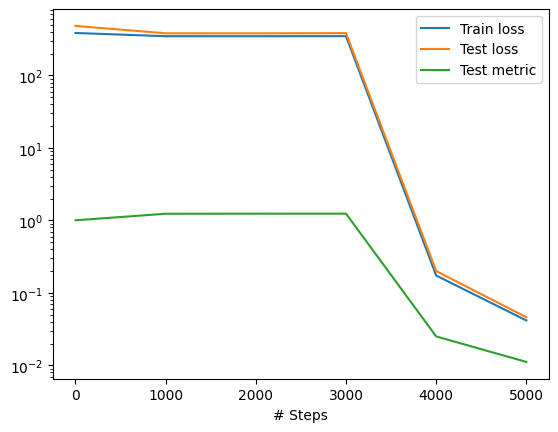

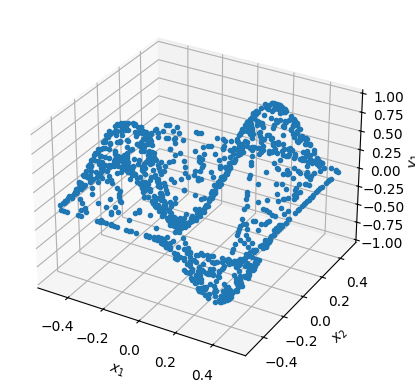

In [10]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)


Relative error =  0.009828902367702437


C:\Users\pc\AppData\Local\Temp\ipykernel_10420\1214603475.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap("seismic"),
C:\Users\pc\AppData\Local\Temp\ipykernel_10420\1214603475.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap("seismic"),


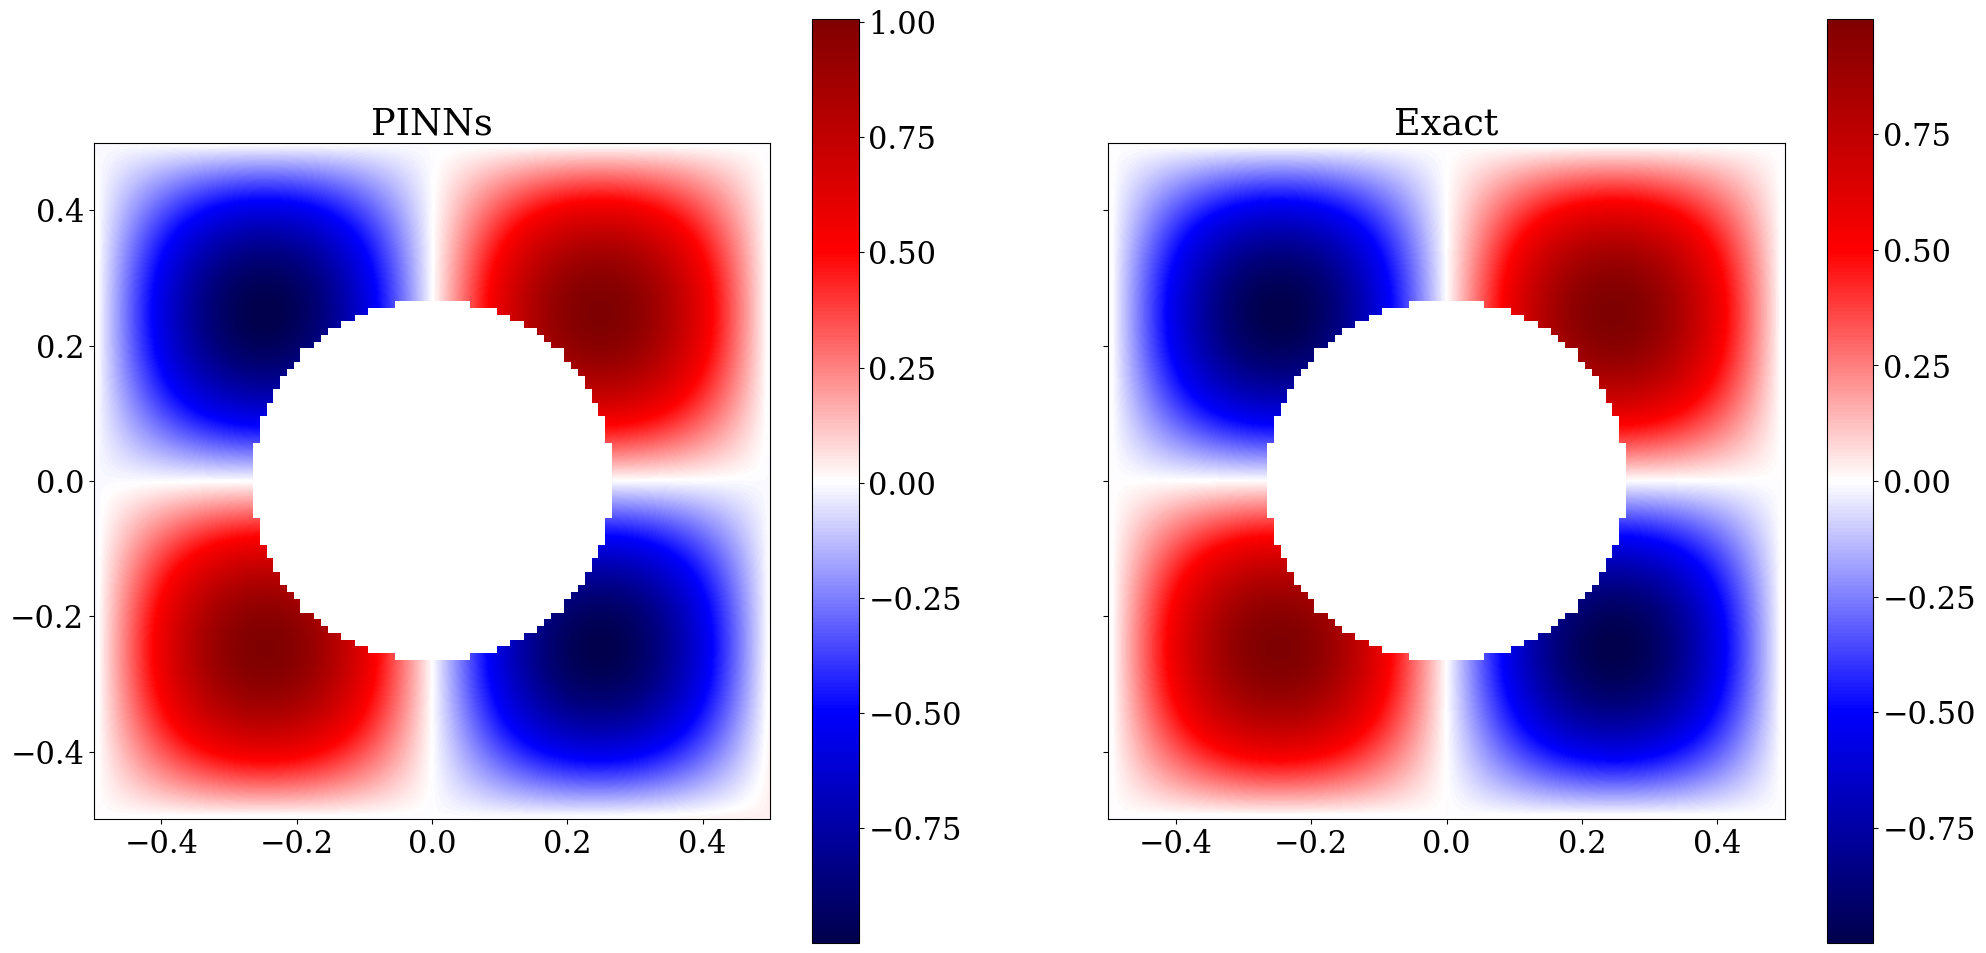

In [12]:
Nx = int(np.ceil(wave_len * 100))
Ny = Nx

length= l
# Grid points
xmin, xmax, ymin, ymax = [-length / 2, length / 2, -length / 2, length / 2]
plot_grid = np.mgrid[xmin : xmax : Nx * 1j, ymin : ymax : Ny * 1j]
points = np.vstack(
    (plot_grid[0].ravel(), plot_grid[1].ravel(), np.zeros(plot_grid[0].size))
)

points_2d = points[:2, :]
u = model.predict(points[:2, :].T)
u = u.reshape((Nx, Ny))

ide = np.sqrt(points_2d[0, :] ** 2 + points_2d[1, :] ** 2) < R
ide = ide.reshape((Nx, Nx))

u_exact = func(points.T)
u_exact = u_exact.reshape((Nx, Ny))
diff = u_exact - u
error = np.linalg.norm(diff) / np.linalg.norm(u_exact)
print("Relative error = ", error)

plt.rc("font", family="serif", size=22)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(24, 12))

matrix = np.fliplr(u).T
matrix = np.ma.masked_where(ide, matrix)
pcm = ax1.imshow(
    matrix,
    extent=[-length / 2, length / 2, -length / 2, length / 2],
    cmap=plt.cm.get_cmap("seismic"),
    interpolation="spline16",
    label="PINN",
)

fig.colorbar(pcm, ax=ax1)

matrix = np.fliplr(u_exact).T
matrix = np.ma.masked_where(ide, matrix)
pcm = ax2.imshow(
    matrix,
    extent=[-length / 2, length / 2, -length / 2, length / 2],
    cmap=plt.cm.get_cmap("seismic"),
    interpolation="spline16",
    label="Exact",
)

ax1.set_title("PINNs")
ax2.set_title("Exact")
fig.colorbar(pcm, ax=ax2)

#p = inner.random_boundary_points(16 * nx_train)
#px, py = p.T
#nx, ny = inner.boundary_normal(p).T
#ax1.quiver(px, py, nx, ny)
#ax2.quiver(px, py, nx, ny)
##plt.savefig("plot_manufactured.pdf")